# Homework 2: Classification With Support Vector Machines


## Setup and Loading Data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
plt.close('all')

In [2]:
# https://archive.ics.uci.edu/ml/datasets/Adult
def loadData(columns):
    training = pd.read_csv('./data/train.txt', header=None)
    training_labels = training.iloc[:,-1]
    testing = pd.read_csv('./data/test.txt', header=None, usecols=columns)
    return training[columns], training_labels,  testing

In [3]:
def createScaler(data): 
    scaler = StandardScaler()
    return scaler.fit(data)

In [4]:
def scaleData(trainingData, testingData): 
    scaler = createScaler(trainingData)
    training_scaled = scaler.transform(trainingData)
    testing_scaled = scaler.transform(testingData)
    return pd.DataFrame(training_scaled), pd.DataFrame(testing_scaled)

In [5]:
def splitDataAtRandom(data, trainingSize=.9):
    split_index = int(data.shape[0] * trainingSize)
    indexes = np.arange(data.shape[0])
    np.random.shuffle(indexes)
    return data.iloc[indexes[0:split_index]], data.iloc[indexes[split_index:]]

In [6]:
def getRandomData(data, size=50):
    return data.sample(size)

In [7]:
continuous_columns = [0,2,4,10,11,12]

In [8]:
training, training_labels, testing = loadData(continuous_columns)
print(f"Loaded {training.shape[0]} training rows, {training_labels.shape[0]} training labels, and {testing.shape[0]} testing rows")

Loaded 43957 training rows, 43957 training labels, and 4885 testing rows


In [9]:
cleaned_labels = training_labels.map(lambda x: x.strip())
cleaned_labels = cleaned_labels.replace('>50K', 1)
cleaned_labels = cleaned_labels.replace('<=50K', -1)

## Explore

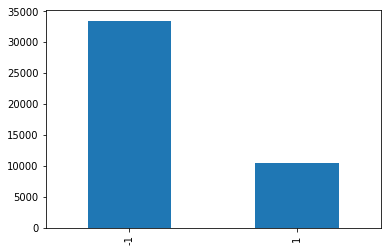

In [10]:
cleaned_labels.value_counts().plot(kind='bar')
plt.show()

In [11]:
training.describe()

,0,2,4,10,11,12
count,43957.000000,4.395700e+04,43957.000000,43957.000000,43957.000000,43957.000000
mean,38.635121,1.897506e+05,10.078531,1088.224538,86.624337,40.413768
std,13.709061,1.059574e+05,2.566403,7548.199742,400.228624,12.326645
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175670e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.779740e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376300e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


## Scale Data

In [12]:
training_scaled, testing_scaled = scaleData(training, testing)

## Train

In [13]:
def calculateHingeLoss(confidence, labels):
    loss = 1 - confidence * labels
    loss[loss < 0] = 0
    return loss

In [14]:
def calculateConfidence(X, w, b):
    return X @ w + b

def makePrediction(data, w, b):
    predictions = []
    for c in calculateConfidence(data,w,b):
        if c >= 0:
            predictions.append(1)
        else:
            predictions.append(-1)
    return np.array(predictions)

In [15]:
def calculateAccuracy(true_labels, predictions):
    accuracy = 0
    for index in range(len(true_labels)):
        if(true_labels.iloc[index] == predictions[index]):
            accuracy +=1

    return (accuracy / len(true_labels))

In [16]:
def sgd(features, b, data, labels, regularization):
    rows_count = data.shape[0]
    confidence = calculateConfidence(data,features,b)
    loss = calculateHingeLoss(confidence, labels)
    cost = np.squeeze(np.sum(loss) / rows_count + regularization * features.transpose() @ features / 2)
    
    has_loss = loss > 0
    dw = np.array(np.sum(has_loss * labels * data.transpose(), axis = 1) / rows_count - regularization * features)
    db = np.sum(has_loss * labels) / rows_count - regularization * b
    
    return dw, db, cost

In [34]:
def train(training_data, labels):
    regularizations = [1e-4, 1e-3, 1e-2, 1e-1, 1]
    accuraciesByReg = {}
    coefficientsByReg = {}
    epochs = 100
    batch_size = 20
    evaluate_step = 30
    steps = 390
    held_out_amount = 50
    best_accuracy = 0
    best_reg = None
    
    for regularization in regularizations:
        print(f"Regularization {regularization}")
        train, test = splitDataAtRandom(training_data)
        test_labels = labels.iloc[test.index.values.tolist()]
        features, b = np.zeros((6,)), 0.0
        best_accuracy = 0
        all_accuracies = []
        all_costs = []
        all_features = []
        
        for epoch in tqdm(range(epochs)):
            held_out_test = getRandomData(train, held_out_amount)
            held_out_labels = labels.iloc[held_out_test.index.values.tolist()]
            
            train_rest = train.drop(held_out_test.index.values.tolist())
            
            for step in range(steps):
                step_train = getRandomData(train, batch_size)
                step_train_labels = labels.iloc[step_train.index.values.tolist()]
                
                dw,db,cost = sgd(features, b, step_train, step_train_labels, regularization)
                
                if step % evaluate_step == 0:
                    held_out_predictions = makePrediction(held_out_test,features,b)
                    accuracy = calculateAccuracy(held_out_labels, held_out_predictions)
                    all_accuracies.append(accuracy)
                    all_costs.append(cost)
                    all_features.append(np.linalg.norm(features))
                    
                learning_rate = 1 / (0.1 * epoch + batch_size)
                features += learning_rate * dw
                b += learning_rate * db
        
        test_predictions = makePrediction(test, features, b)
        rate_accuracy = calculateAccuracy(test_labels, test_predictions)
        
        if rate_accuracy > best_accuracy:
            best_accuracy = rate_accuracy
            best_reg = regularization
            
        accuraciesByReg[str(regularization)] = all_accuracies
        coefficientsByReg[str(regularization)] = all_features
    return accuraciesByReg, coefficientsByReg, best_reg, best_accuracy

In [29]:
def plotAccuracies(accuraciesByReg):
    for name, data in accuraciesByReg.items():
        plt.plot(data, label=name)
    plt.title('Regularization Accuracies')
    plt.xlabel('Steps')
    plt.ylabel('Accurancy')
    plt.legend()
    plt.show()

In [30]:
def plotCoefficient(data):
    for name, d in data.items():
        plt.plot(d, label=name)
    plt.title('Coefficient Magnitude')
    plt.xlabel('Steps')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.show()

In [ ]:
accuraciesByReg, coefficientsByReg, best_reg, best_accuracy = train(training_scaled, cleaned_labels)

  0%|          | 0/100 [00:00<?, ?it/s]

Regularization 0.0001


  4%|▍         | 4/100 [00:04<01:49,  1.14s/it]

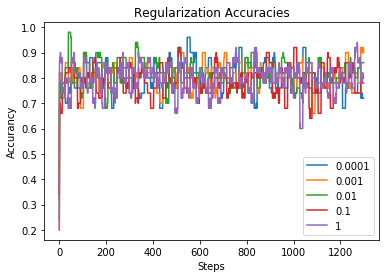

In [32]:
plotAccuracies(accuraciesByReg)

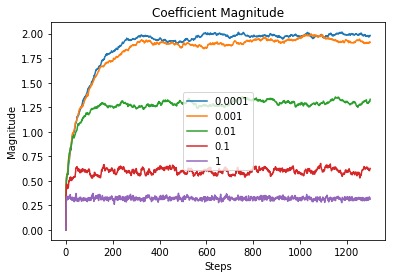

In [33]:
plotCoefficient(coefficientsByReg)